## File per il confronto tra autoencoder

Prova a copiare quello che viene fatto nel paper per quanto riguarda AE-NMF. Da testare ancora classico.


In [17]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import scipy.spatial as sp
from sklearn.model_selection import train_test_split
from functions import reconstruction_error, signature_matching
from scipy.optimize import linear_sum_assignment, nnls

In [2]:
# Load the .tsv file
data = pd.read_csv("data/GEL_data/catalogues_Ovary_SBS.tsv", sep="\t")


train, test = train_test_split(data.T, test_size=0.2)

train = train.T
test = test.T

print(train.shape)
print(test.shape)


(96, 418)
(96, 105)


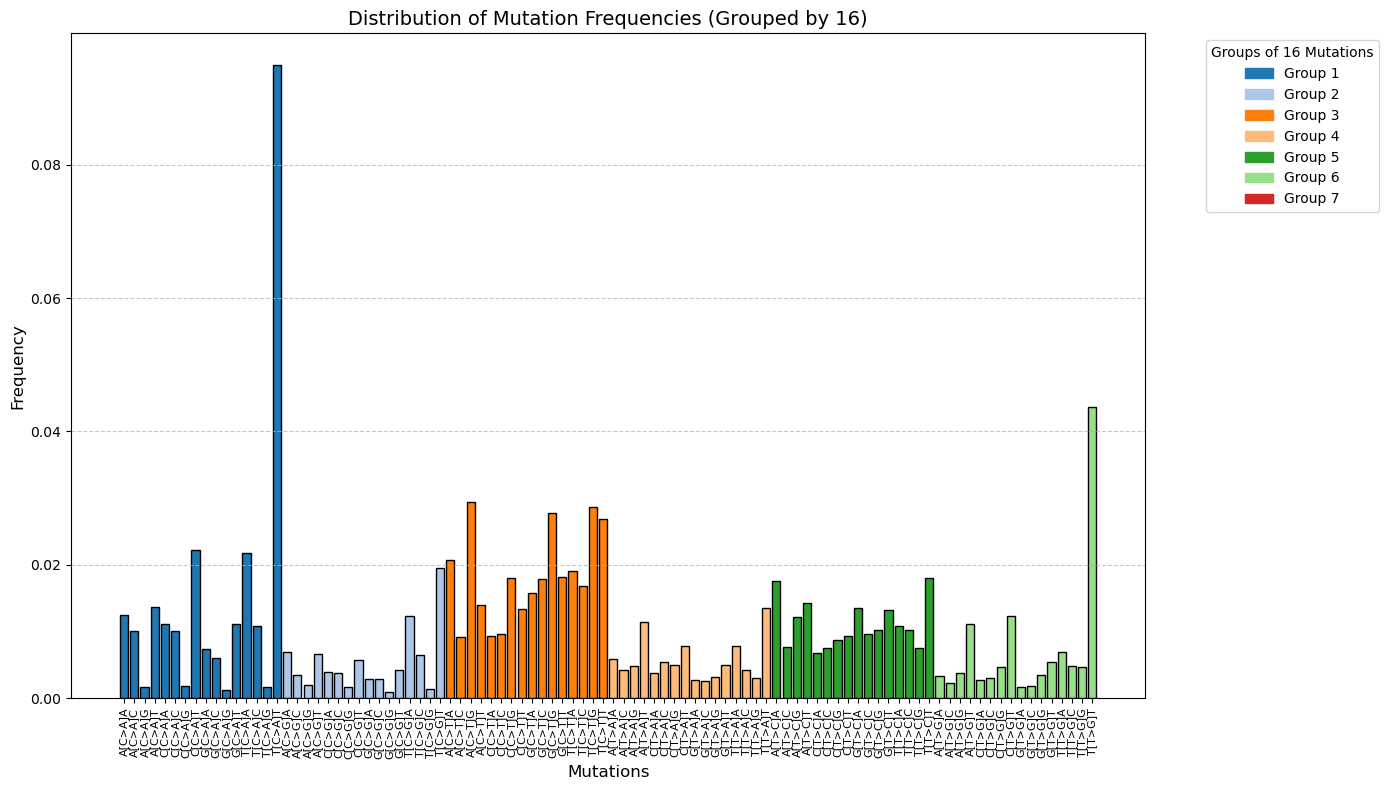

In [3]:
# Calculate the total counts for each mutation across patients
mutation_sums = data.sum(axis=1)

# Convert counts to frequencies
mutation_frequencies = mutation_sums / mutation_sums.sum()

# Group mutations into sets of 16 for coloring
num_groups = (len(mutation_frequencies) // 16) + 1
colors = plt.cm.tab20.colors  # Use a colormap with distinct colors

# Assign a color to each group of 16
bar_colors = [colors[i // 16 % len(colors)] for i in range(len(mutation_frequencies))]

# Plot the histogram
plt.figure(figsize=(14, 8))
bars = plt.bar(
    mutation_frequencies.index,
    mutation_frequencies.values,
    color=bar_colors,
    edgecolor="black",
)

# Customizing the x-axis for readability
plt.xticks(rotation=90, fontsize=8)
plt.title("Distribution of Mutation Frequencies (Grouped by 16)", fontsize=14)
plt.xlabel("Mutations", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add legend for groups of 16
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(num_groups)]
labels = [f"Group {i+1}" for i in range(num_groups)]
plt.legend(handles, labels, title="Groups of 16 Mutations", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()


In [4]:
from models import AE_NMF, CNMF, NMF_liz

In [5]:
# Pass it transposed

autoencoder = AE_NMF.AE_NMF(input_dim = train.shape[1], latent_dim = 4, constraint='pg')

In [6]:
result = AE_NMF.train(model = autoencoder,
                       training_data = train,
                       criterion = torch.nn.MSELoss(reduction = 'mean'),
                       optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4),
                       tol =  1e-10,
                       relative_tol=True,
                       max_iter = 10000000)

In [7]:
loss = result[1]
signature = result[2]
exposures_train = result[3]
enc_mat = result[4]

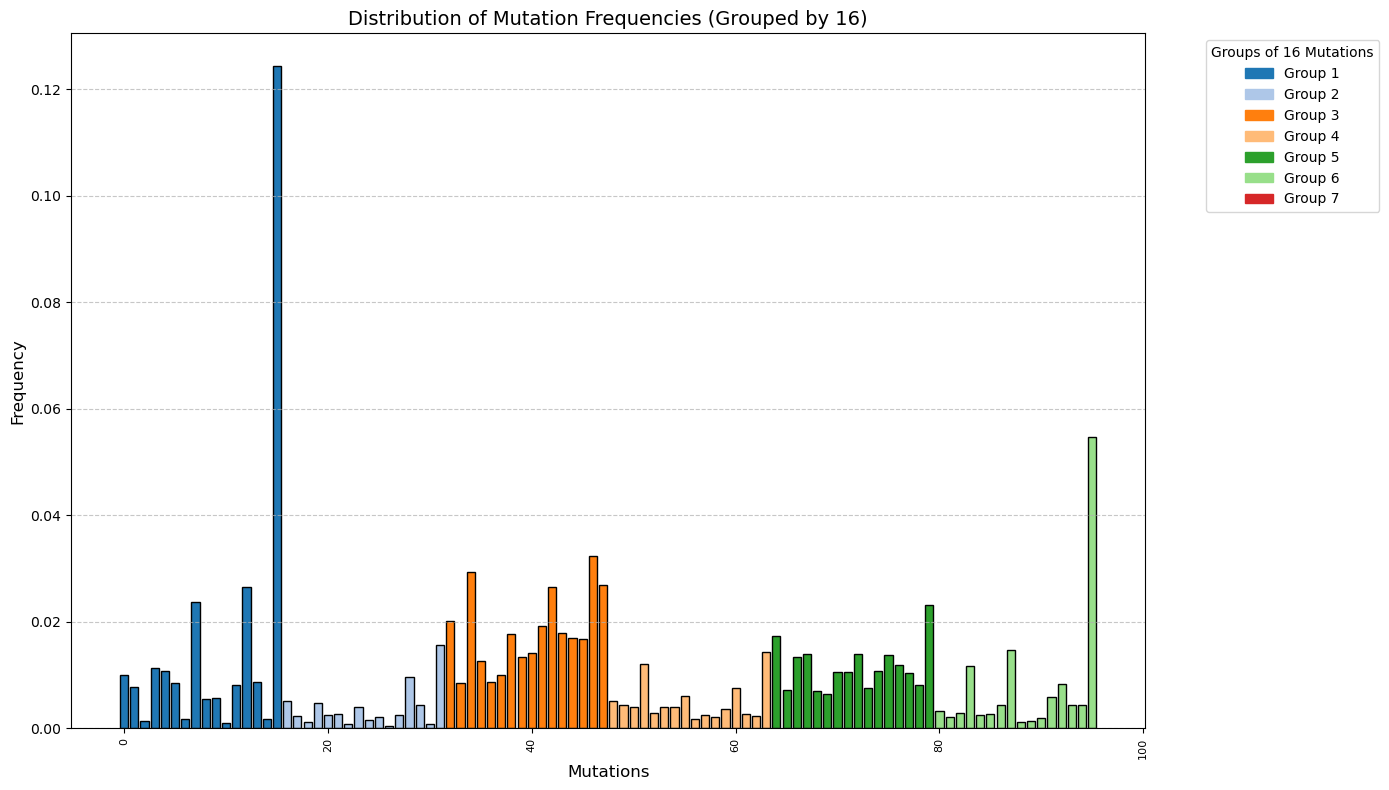

In [8]:
data1 = signature@exposures_train

data = pd.DataFrame(data1, columns=train.columns)

# Calculate the total counts for each mutation across patients
mutation_sums = data.sum(axis=1)

# Convert counts to frequencies
mutation_frequencies = mutation_sums / mutation_sums.sum()

# Group mutations into sets of 16 for coloring
num_groups = (len(mutation_frequencies) // 16) + 1
colors = plt.cm.tab20.colors  # Use a colormap with distinct colors

# Assign a color to each group of 16
bar_colors = [colors[i // 16 % len(colors)] for i in range(len(mutation_frequencies))]

# Plot the histogram
plt.figure(figsize=(14, 8))
bars = plt.bar(
    mutation_frequencies.index,
    mutation_frequencies.values,
    color=bar_colors,
    edgecolor="black",
)

# Customizing the x-axis for readability
plt.xticks(rotation=90, fontsize=8)
plt.title("Distribution of Mutation Frequencies (Grouped by 16)", fontsize=14)
plt.xlabel("Mutations", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add legend for groups of 16
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(num_groups)]
labels = [f"Group {i+1}" for i in range(num_groups)]
plt.legend(handles, labels, title="Groups of 16 Mutations", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
diagonals = signature.sum(axis = 0)
exposures = np.diag(diagonals)@exposures_train
signatures = signature@np.diag(1/diagonals)

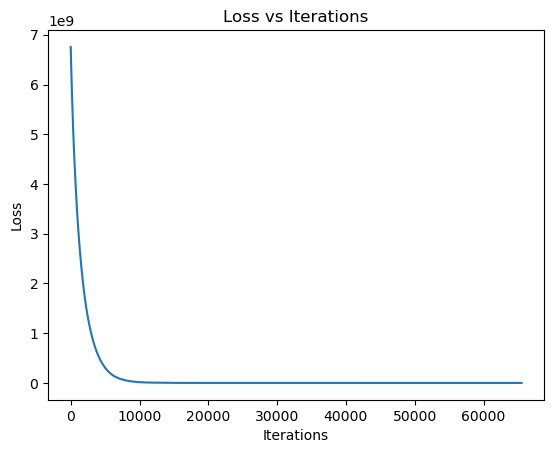

Last Loss:  138393.90625


In [ ]:
# plot the loss

plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()

print("Last Loss: ", loss[-1])

In [25]:

out_error_AE = reconstruction_error(test, signatures)

print(f"Error: {out_error_AE}")

Error: 12539.626405652156


In [ ]:
print(signature.shape)

(96, 4)
